In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd

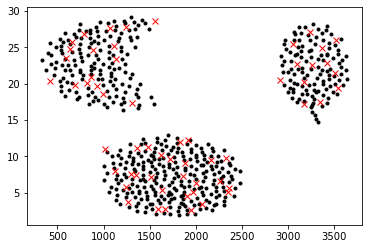

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

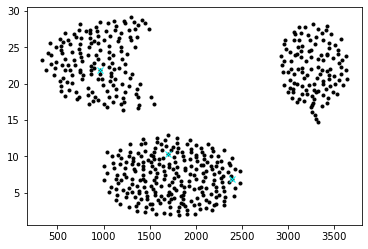

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(data, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

In [4]:
def kmeans(array, k):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        distances = spsd.cdist(array, centers)
        indices = np.argmin(distances, axis=1)
        print(indices)
        
        # falta agrupar os valores, tirar a média da posição por cluster e alterar os centros
        
        # deveria ser falso somente quando centros não estão se movendo (ou estão movendo pouco)
        changed = False
    return centers
cluster_centers = kmeans(data, 3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 